In [3]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2022-10-07 17:11:39.489203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# load file
filepath = "../Data/creditcard.csv"
df = pd.read_csv(filepath)

In [5]:
# identify X features, and y class
# Those data have been used froom creditCard notbook, EDA
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state = 42)

In [6]:
# Normalize data, scale to [0,1]
#train_data = StandardScaler().fit_transform(X_train)
#test_data = StandardScaler().fit_transform(X_test)
train_data = MinMaxScaler().fit_transform(X_train)
test_data = MinMaxScaler().fit_transform(X_test)
train_labels = y_train
test_labels = y_test

In [7]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [8]:
# Auto encoder with keras dense layers
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="tanh"),
      layers.Dropout(0.35),
      layers.Dense(16, activation="tanh"),
      layers.Dense(8, activation="tanh")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="tanh"),
      layers.Dropout(0.35),
      layers.Dense(32, activation="tanh"),
      layers.Dense(30, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

2022-10-07 17:11:52.304664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# second method to keras sequential model build
encoder = tf.keras.models.Sequential([tf.keras.layers.Reshape(([30,1,1]),input_shape=[30]),
    layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='tanh'),
    layers.Dropout(0.1),
      layers.Dense(32, activation="tanh"),
      layers.Dense(16, activation="tanh"),
      layers.Dense(8, activation="tanh")])

decoder = tf.keras.models.Sequential([
      layers.Dense(16, activation="tanh"),
      layers.Dense(32, activation="tanh"),
      layers.Dropout(0.1),
      layers.Conv2DTranspose(32,kernel_size=(3,3), padding='same', activation='tanh'),
      layers.Dense(1, activation="sigmoid"),
      tf.keras.layers.Reshape([1,30])])

autoencoder2 = tf.keras.models.Sequential([encoder,decoder])

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(loss='binary_crossentropy', optimizer=opt)
autoencoder2.compile(loss='binary_crossentropy', optimizer=opt)

In [11]:
# train the data
from gc import callbacks


log_dir = "logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=30, 
          batch_size=52,
          validation_data=(test_data, test_data),
          shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/30
8/8 [==============================] - 4s 445ms/step - loss: 0.6906 - val_loss: 0.6953
Epoch 2/30
8/8 [==============================] - 2s 319ms/step - loss: 0.6725 - val_loss: 0.6927
Epoch 3/30
8/8 [==============================] - 2s 348ms/step - loss: 0.6561 - val_loss: 0.6916
Epoch 4/30
8/8 [==============================] - 2s 279ms/step - loss: 0.6429 - val_loss: 0.6908
Epoch 5/30
8/8 [==============================] - 2s 319ms/step - loss: 0.6318 - val_loss: 0.6917
Epoch 6/30
8/8 [==============================] - 2s 267ms/step - loss: 0.6255 - val_loss: 0.6911
Epoch 7/30
8/8 [==============================] - 2s 262ms/step - loss: 0.6219 - val_loss: 0.6898
Epoch 8/30
8/8 [==============================] - 2s 228ms/step - loss: 0.6192 - val_loss: 0.6883
Epoch 9/30
8/8 [==============================] - 1s 210ms/step - loss: 0.6169 - val_loss: 0.6865
Epoch 10/30
8/8 [==============================] - 2s 252ms/step - loss: 0.6159 - val_loss: 0.6821
Epoch 11/30
8/8 [==

In [ ]:
print('Dense layer training result')
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [12]:
log_dir2 = "logs/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
history2 = autoencoder2.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=52,
          validation_data=(test_data, test_data),
          shuffle=True, callbacks=[tensorboard_callback2])

Epoch 1/20
8/8 [==============================] - 6s 686ms/step - loss: 0.6792 - val_loss: 0.6489
Epoch 2/20
8/8 [==============================] - 4s 618ms/step - loss: 0.6460 - val_loss: 0.6340
Epoch 3/20
8/8 [==============================] - 4s 603ms/step - loss: 0.6384 - val_loss: 0.6302
Epoch 4/20
8/8 [==============================] - 4s 541ms/step - loss: 0.6357 - val_loss: 0.6272
Epoch 5/20
8/8 [==============================] - 4s 528ms/step - loss: 0.6342 - val_loss: 0.6268
Epoch 6/20
8/8 [==============================] - 4s 515ms/step - loss: 0.6331 - val_loss: 0.6241
Epoch 7/20
8/8 [==============================] - 4s 505ms/step - loss: 0.6323 - val_loss: 0.6243
Epoch 8/20
8/8 [==============================] - 4s 504ms/step - loss: 0.6316 - val_loss: 0.6231
Epoch 9/20
8/8 [==============================] - 4s 525ms/step - loss: 0.6310 - val_loss: 0.6229
Epoch 10/20
8/8 [==============================] - 4s 548ms/step - loss: 0.6303 - val_loss: 0.6228
Epoch 11/20
8/8 [==

Dense layer training result


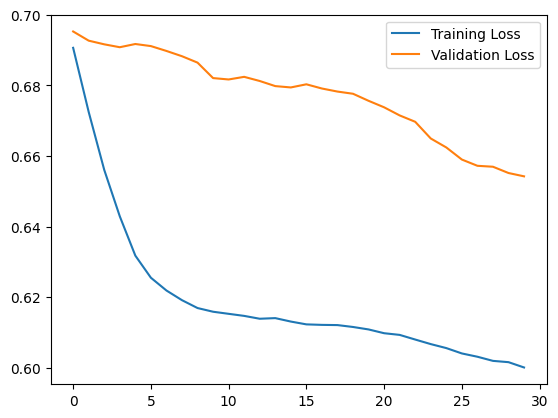

Conv2D layer training result


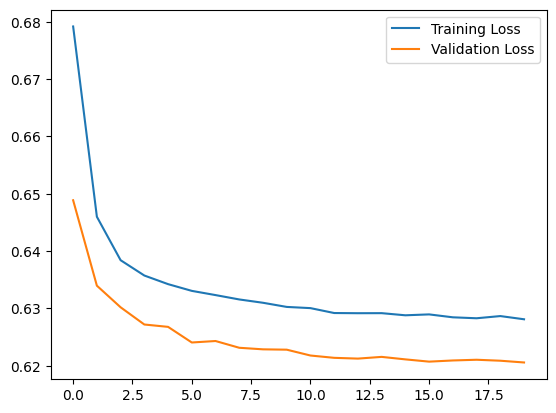

In [13]:


print('Conv2D layer training result')
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

13/13 [==============================] - 0s 3ms/step


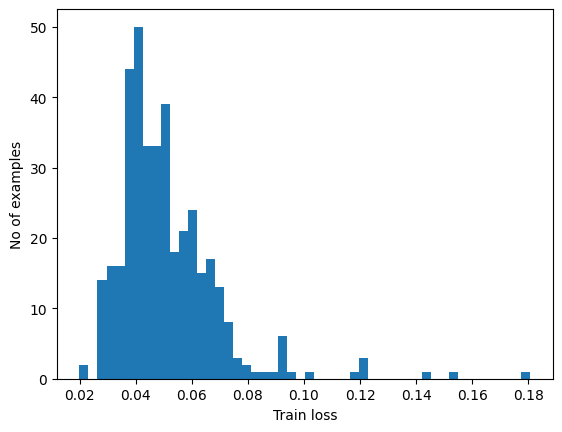

In [14]:
# plot the reconstuct error vs normal 
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

reconstructions2 = autoencoder2.predict(normal_train_data)
train_loss2 = tf.keras.losses.mae(reconstructions2, normal_train_data)
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

threshold2 = np.mean(train_loss2) + np.std(train_loss2)
print("Threshold: ", threshold2)

Threshold:  0.06940157847401066
Threshold:  0.1303653462680316


In [16]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.binary_crossentropy(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [17]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)



Accuracy = 0.998139110284049
Precision = 0.0
Recall = 0.0


/Users/michael/opt/anaconda3/envs/anomaly/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 

: 

In [ ]:
print("Dense layer only confusion matrix")
tf.math.confusion_matrix(
    test_labels,
    preds,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

Dense layer only confusion matrix


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[56856,     0],
       [  106,     0]], dtype=int32)>

In [ ]:
preds2 = predict(autoencoder2, test_data, threshold2)
print_stats(preds2, test_labels)

In [ ]:
print("Conv2D layer only confusion matrix")
tf.math.confusion_matrix(
    test_labels,
    preds2,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

Conv2D layer only confusion matrix


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[56856,     0],
       [  106,     0]], dtype=int32)>

In [ ]:
%load_ext tensorboard